---
---
# **Normalizing Flow**
---
---

## Basics

Normalizing flows are models aiming at learning the distribution of some random variable $\vec{y}$ starting from a known _base_ distribution associated to a variable $\vec{x}$. 
The core of this approach lies in the simple well-known formula
$$ f_Y(\vec{y}) = | J^{-1} (\vec{y})| f_X ( \vec{x}(\vec{y})) $$
where $f_X$ is the base distribution, $f_Y$ is the distribution of $\vec{y}$ and $|J^{-1}| = \det \left(\frac{\partial y_a}{\partial x_b}\right)^{-1}$ is the Jacobian of the transformation $ \vec{y} = \vec{y}(\vec{x})$. The model then finds the best transformation by minimizing the negative log-likelihood
$$L = - \sum_i \log f_Y (\vec{y}_i) = - \sum_i \log f_X (\vec{x}(\vec{y}_i)) - \sum_i  | J^{-1} (\vec{y_i})|.$$

There are several ways to define the transformation. A common and effective approach is the realNVP one, in which one defines a set of simply invertible transformations, called **affine layers**, by splitting the data in two ensembles. To show how this work, consider for simplicity the 2-d case. Defining the variables as $\vec{y}=(y_A, y_B)$ and $\vec{x}=(x_A, x_B)$, an affine layer can be defined via 
$$
\begin{cases}
y_A =  x_A \\
y_B = e^{s_1(x_A)} x_B + t_1(x_A)
 \end{cases} \longrightarrow 
 \begin{cases}
x_A =  z_A \\
x_B = e^{-s_1(y_A)}  (y_B -t_1 (y_A))
 \end{cases}.
$$
It is easy to see that the Jacobian of this transformation is simply the scale factor, $|J^{-1}| = e^{-s_1}$. One can introduce several middle layers of this kind (eventually permuting the $A$ and $B$ sets to ensure more flexibility). Employing the chain rule, the overall Jacobian factor is simply the product of the single Jacobians, which are always of the form $e^{-s_k}$. This means that the overall loss function (aka the negative log-likelihood) simply reads
$$L = -\sum_i \log f_X (\vec{x}(\vec{y}_i)) + \sum_{i} \sum_k  s_k (\vec{y_i}).$$
The transformations $s_k, t_k$ are typically modelled with a neural network, which is then trained by minizing the loss function.

## This notebook

In this notebook, we'll:

1. Define a **flexible normalizing flow** with an arbitrary number of **affine coupling layers** to learn a 2-d distribution starting from a Standard 2-d Gaussian.
2. Generate a 2D dataset with **two Gaussian peaks** located at different points.
3. Visualize the **true data**, **base distribution**, and **learned distribution**.

---
# **Setup**

### **1. Imports and Basic Setup**

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import multiprocessing
import warnings

warnings.filterwarnings('ignore')  # To suppress warnings for cleaner output

# Choose device:
# 1) CUDA if available
# 2) Else MPS if available (Apple Silicon)
# 3) Else CPU

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    torch.set_num_threads(multiprocessing.cpu_count())

print("Using device:", device)

Using device: cpu


### **2. Flow Model and Base Distribution**
We'll define:
- A flexible normalizing flow that can have **any number** of affine layers.
- The loss function.
- A base distribution $f_X$, which is a standard normal in 2D.

In [ ]:
# -------------- FLOW MODEL

class AffineFlow(nn.Module):
    def __init__(self, num_layers, s_neurons, t_neurons, p=0.2):
        """
        A flexible flow with num_layers affine transformations.
        Each layer has an s-network and a t-network.
        """
        super(AffineFlow, self).__init__()
        self.num_layers = num_layers

        self.s_layers = nn.ModuleList()
        self.t_layers = nn.ModuleList()

        # Create num_layers affine transformations
        for _ in range(num_layers):
            # Scale network
            s_net = nn.Sequential(
                nn.Linear(1, s_neurons[0]),
                nn.Dropout(p),
                nn.ReLU(),
                nn.Linear(s_neurons[0], s_neurons[1]),
                nn.Dropout(p),
                nn.ReLU(),
                nn.Linear(s_neurons[1], 1)
            )

            # Translation network
            t_net = nn.Sequential(
                nn.Linear(1, t_neurons[0]),
                nn.Dropout(p),
                nn.ReLU(),
                nn.Linear(t_neurons[0], t_neurons[1]),
                nn.Dropout(p),
                nn.ReLU(),
                nn.Linear(t_neurons[1], 1)
            )

            self.s_layers.append(s_net)
            self.t_layers.append(t_net)

    def inverse_forward(self, y):
        """
        Compute x = f^{-1}(y) by sequentially applying the inverse of all affine layers.
        We store and return the scale outputs to compute the correct log-determinant.
        """
        yA = y[:, 0:1]
        yB = y[:, 1:2]
        scale_outputs = []  # Will store s_l for each layer

        # We invert the flow by going in reverse order of layers
        for i in range(self.num_layers-1,-1,-1):
            s_out = self.s_layers[i](yA)
            t_out = self.t_layers[i](yA)

            # zB = yA
            # zA = exp(-s_out) * (yB - t_out)
            zB = yA
            zA = torch.exp(-s_out) * (yB - t_out)

            # Now swap roles for the next layer
            yA, yB = zA, zB

            scale_outputs.append(s_out)  # We'll need this for the loss

        return yA, yB, scale_outputs

    def forward(self, x):
        """
        Compute y = f(x) by sequentially applying the forward transformations.
        This is useful for sampling from the flow.
        """
        xA = x[:, 0:1]
        xB = x[:, 1:2]

        for i in range(self.num_layers):
            s_out = self.s_layers[i](xA)
            t_out = self.t_layers[i](xA)

            # zA = xA
            # zB = xB * exp(s_out) + t_out
            zA = xA
            zB = xB * torch.exp(s_out) + t_out

            # swap
            xA, xB = zB, zA

        return torch.cat([xA, xB], dim=1)

# -------------- LOSS FUNCTION

def negative_log_likelihood(f_X, xA, xB, scale_outputs):
    """
    -log p_Y(y) = - log p_X(x) + sum_{all_layers}( s_l )
    
    scale_outputs: list of scale function outputs s_l.
    """
    # Clamp to avoid log(0)
    log_pX = torch.log(torch.clamp(f_X(xA, xB), min=1e-9))

    # Summation of all scale terms s_l from each layer
    # Because for the inverse we have exp(-s_l), it contributes +s_l in the log-det
    log_det_sum = 0
    for s_l in scale_outputs:
        log_det_sum = log_det_sum + s_l

    # Final loss is sum across the batch
    loss = torch.sum(-log_pX + log_det_sum)
    return loss

# -------------- BASE DISTRIBUTON
def f_X(xA, xB):
    """
    Base distribution: standard Gaussian in 2D.
    p_X(xA, xB) = (1 / 2π) * exp(-0.5 * (xA^2 + xB^2))
    """
    return torch.exp(-0.5 * (xA**2 + xB**2)) / (2.0 * np.pi)

### **3. Training Loop Definition**
We include:
- **Mini-batch** training
- **Early stopping**
- **Adaptive learning rate** with `ReduceLROnPlateau`

In [32]:
def train_flow(model, optimizer, y_train, epochs=200, batch_size=128, patience=20,
               lr_scheduler=True, print_every=10):
    """
    Train the normalizing flow with mini-batches, early stopping, and LR scheduling.
    """
    dataset = TensorDataset(y_train)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    best_loss = float('inf')
    patience_counter = 0
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                          factor=0.5, patience=5, verbose=False)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        for batch in dataloader:
            y_batch = batch[0]

            # 1) Zero gradients
            optimizer.zero_grad()

            # 2) Inverse pass: y -> x
            xA, xB, scale_outputs = model.inverse_forward(y_batch)

            # 3) Compute loss
            loss = negative_log_likelihood(f_X, xA, xB, scale_outputs)

            # 4) Backprop
            if torch.isnan(loss).any():
                print("NaN detected! Stopping training.")
                return
            
            loss.backward()

            # Clip gradients to avoid explosion
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)

            # 5) Update
            optimizer.step()

            epoch_loss += loss.item()

        # Adjust LR if using ReduceLROnPlateau
        if lr_scheduler:
            scheduler.step(epoch_loss)

        # Early stopping check
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best loss: {best_loss:.4f}")
            break

        # Print progress
        if (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

    print("Training complete.")
    print(f"Best loss achieved: {best_loss:.4f}")

--- 
# **Application**

### **1. Data Generation**


We'll generate a dataset from a mixture of two Gaussians centered in different points.

In [5]:
def generate_two_gaussian_data(mean1, mean2, n_samples = 2000):
    """
    Generate a dataset from a mixture of two Gaussians at (1,1) and (-1,-1).
    Each has covariance = 2x2 identity.
    """
    n1 = n_samples // 2
    n2 = n_samples - n1
    cov = np.eye(2)

    # Draw samples from each Gaussian
    data1 = np.random.multivariate_normal(mean1, cov, size=n1)
    data2 = np.random.multivariate_normal(mean2, cov, size=n2)

    data = np.vstack([data1, data2]).astype(np.float32)
    np.random.shuffle(data)
    return data

# Generate data
sample_size = 10**4
mean1 = np.array([1.5, 1.5])
mean2 = np.array([-1.5, -1.5])
data_np = generate_two_gaussian_data(mean1, mean2, sample_size)
# Convert to PyTorch tensor and move to device
y_train = torch.from_numpy(data_np).to(device)
print("Data shape:", y_train.shape)

Data shape: torch.Size([10000, 2])


### **2. Training**
We'll instantiate the model with a chosen number of layers, train it, and visualize the base distribution and the learned distribution.

In [37]:
# Hyperparameters for the flow
num_layers = 5                
s_neurons = (3, 5)
t_neurons = (3, 5)
dropout_rate = 0.0          
lr = 0.001
epochs = 500
batch_size = 256
patience = 20

# Instantiate model
model = AffineFlow(num_layers, s_neurons, t_neurons, p=dropout_rate).to(device)
print(f"Learnable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

optimizer = optim.Adam(model.parameters(), lr=lr)

# Train
train_flow(model, optimizer, y_train, epochs=epochs, batch_size=batch_size,
           patience=patience, lr_scheduler=True, print_every=20)

Learnable parameters: 320
Epoch 20/500, Loss: 35284.9163
Epoch 40/500, Loss: 35119.5060
Epoch 60/500, Loss: 35031.4707
Epoch 80/500, Loss: 34996.4100
Epoch 100/500, Loss: 34954.2600
Epoch 120/500, Loss: 34935.4316
Epoch 140/500, Loss: 34923.7262
Epoch 160/500, Loss: 34923.0237
Epoch 180/500, Loss: 34922.9003
Epoch 200/500, Loss: 34922.8936
Epoch 220/500, Loss: 34922.8937
Early stopping at epoch 223. Best loss: 34922.8932
Training complete.
Best loss achieved: 34922.8932


### **3. Learned Distribution**

We'll sample from the **standard normal** (our base) and plot it, together with the synthetic training data distribution and learned distribution.

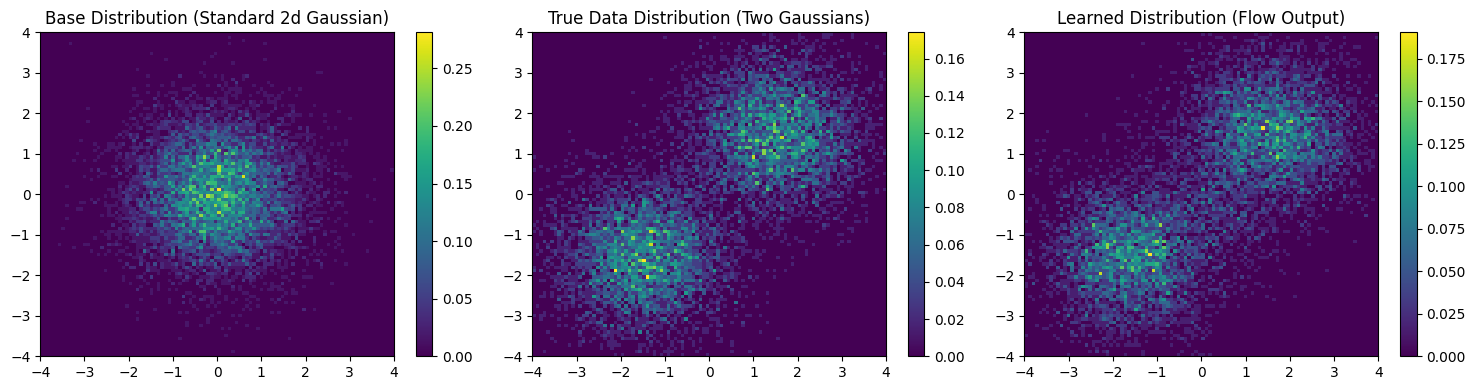

In [38]:
def sample_from_model(model, x_base):
    """Pass base samples through the trained model to generate transformed samples."""
    x_base = torch.tensor(x_base, dtype=torch.float32)  # Ensure correct dtype
    model.eval()
    with torch.no_grad():
        y_out = model.forward(x_base)  # shape [N,2]
    return y_out.cpu().numpy()

def plot_distributions(data1, data2, data3, bins=100, xy_limits=[-4,4]):
    """Plots 3 density distributions side by side with fixed axis limits."""
    fig, axes = plt.subplots(1, 3, figsize=(15,4))
    # Define bin range for consistency
    bin_range = [[xy_limits[0], xy_limits[1]], [xy_limits[0], xy_limits[1]]]
    # Plot Base Distribution
    hist1 = axes[0].hist2d(data1[:,0], data1[:,1], bins=bins, range=bin_range, density=True, cmap='viridis')
    axes[0].set_title("Base Distribution (Standard 2d Gaussian)")
    plt.colorbar(hist1[3], ax=axes[0])
    # Plot True Data Distribution
    hist2 = axes[1].hist2d(data2[:,0], data2[:,1], bins=bins, range=bin_range, density=True, cmap='viridis')
    axes[1].set_title("True Data Distribution (Two Gaussians)")
    plt.colorbar(hist2[3], ax=axes[1])
    # Plot Learned Distribution
    hist3 = axes[2].hist2d(data3[:,0], data3[:,1], bins=bins, range=bin_range, density=True, cmap='viridis')
    axes[2].set_title("Learned Distribution (Flow Output)")
    plt.colorbar(hist3[3], ax=axes[2])

    # Ensure layout is clean
    plt.tight_layout()
    plt.show()

# Generate base distribution samples
N_base = 10**4
x_samp = np.random.randn(N_base, 2).astype(np.float32)

# Generate transformed samples from trained model
y_generated = sample_from_model(model, x_samp)

# Convert y_train to numpy if it's a tensor
y_train_np = y_train.cpu().numpy() if isinstance(y_train, torch.Tensor) else y_train

# Plot all three distributions in one row
plot_distributions(x_samp, y_train_np, y_generated, bins=100, xy_limits=[-4,4])


### **Done!**
The two blobs forming in the "Learned Distribution" plot resemble the original data distribution, meaning the flow is capturing the two-peak structure.
To improve, one can try:
- Increasing `num_layers`.
- Increasing hidden neurons `(s_neurons, t_neurons)`.